In [1]:
## Alternativas para datasets: 

## https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

## https://archive.ics.uci.edu/ml/datasets/Apartment+for+rent+classified

## https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report,confusion_matrix
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from minisom import MiniSom    

## Preambulo: construyendo un SOM en Tensorflow

Extraído de: https://rubikscode.net/2021/07/06/implementing-self-organizing-maps-with-python-and-tensorflow/

In [3]:
class SOM(object):
    def __init__(self, x, y, input_dim, learning_rate, radius, num_iter=111):
        
        #Initialize properties
        self._x = x
        self._y = y
        self._learning_rate = float(learning_rate)
        self._radius = float(radius)
        self._num_iter = num_iter
        self._graph = tf.Graph()
 
        #Initialize graph
        with self._graph.as_default():
            
            #Initializing variables and placeholders
            self._weights = tf.Variable(tf.random_normal([x*y, input_dim]))
            self._locations = self._generate_index_matrix(x, y)
            self._input = tf.placeholder("float", [input_dim])
            self._iter_input = tf.placeholder("float")
 
            #Calculating BMU
            input_matix = tf.stack([self._input for i in range(x*y)])
            distances = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self._weights, input_matix), 2), 1))
            bmu = tf.argmin(distances, 0)
            
            #Get BMU location
            mask = tf.pad(tf.reshape(bmu, [1]), np.array([[0, 1]]))
            size = tf.cast(tf.constant(np.array([1, 2])), dtype=tf.int64)
            bmu_location = tf.reshape(tf.slice(self._locations, mask, size), [2])
 
            #Calculate learning rate and radius
            decay_function = tf.subtract(1.0, tf.div(self._iter_input, self._num_iter))
            _current_learning_rate = tf.multiply(self._learning_rate, decay_function)
            _current_radius = tf.multiply(self._radius, decay_function)
 
            #Adapt learning rate to each neuron based on position
            bmu_matrix = tf.stack([bmu_location for i in range(x*y)])
            bmu_distance = tf.reduce_sum(tf.pow(tf.subtract(self._locations, bmu_matrix), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(bmu_distance, "float32"), tf.pow(_current_radius, 2))))
            learning_rate_matrix = tf.multiply(_current_learning_rate, neighbourhood_func)
 
            #Update all the weights
            multiplytiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_matrix, np.array([i]), np.array([1])), [input_dim])
                                               for i in range(x*y)])
            delta = tf.multiply(
                multiplytiplier,
                tf.subtract(tf.stack([self._input for i in range(x*y)]), self._weights))                
                         
            new_weights = tf.add(self._weights, delta)
            self._training = tf.assign(self._weights, new_weights)                                       
 
            #Initilize session and run it
            self._sess = tf.Session()
            initialization = tf.global_variables_initializer()
            self._sess.run(initialization)
 
    def train(self, input_vects):
        for iter_no in range(self._num_iter):
            for input_vect in input_vects:
                self._sess.run(self._training,
                               feed_dict={self._input: input_vect,
                                          self._iter_input: iter_no})
 
        self._centroid_matrix = [[] for i in range(self._x)]
        self._weights_list = list(self._sess.run(self._weights))
        self._locations = list(self._sess.run(self._locations))
        for i, loc in enumerate(self._locations):
            self._centroid_matrix[loc[0]].append(self._weights_list[i])
  
    def map_input(self, input_vectors):
        return_value = []
        for vect in input_vectors:
            min_index = min([i for i in range(len(self._weights_list))],
                            key=lambda x: np.linalg.norm(vect, self._weights_list[x]))
            return_value.append(self._locations[min_index])
        return return_value
    
    def _generate_index_matrix(self, x,y):
        return tf.constant(np.array(list(self._iterator(x, y))))
    
    def _iterator(self, x, y):
        for i in range(x):
            for j in range(y):
                yield np.array([i, j])

In [4]:
data = pd.read_csv('Airlines.csv')

# Creamos variable delay2 para mapear como variable categórica a Delay

#data['delay2'] = data['Delay'].map({0: 'On Time', 1: 'Delayed'})
data

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0
539379,539380,FL,398,SEA,ATL,5,1439,305,0
539380,539381,FL,609,SFO,MKE,5,1439,255,0
539381,539382,UA,78,HNL,SFO,5,1439,313,1


In [5]:
x = data[['Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length']]

x["Airline"] = x["Airline"].astype('category')
x["AirportFrom"] = x["AirportFrom"].astype('category')
x["AirportTo"] = x["AirportTo"].astype('category')

x["Airline_cat"] = x["Airline"].cat.codes
x["AirportFrom_cat"] = x["AirportFrom"].cat.codes
x["AirportTo_cat"] = x["AirportTo"].cat.codes

x = x.drop(columns=['Airline', 'AirportFrom', 'AirportTo'])
x

/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_6367/1730750444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["Airline"] = x["Airline"].astype('category')
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_6367/1730750444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["AirportFrom"] = x["AirportFrom"].astype('category')
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_6367/1730750444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Flight,DayOfWeek,Time,Length,Airline_cat,AirportFrom_cat,AirportTo_cat
0,269,3,15,205,4,253,135
1,1558,3,15,222,14,217,60
2,2400,3,20,165,1,154,80
3,2466,3,20,195,1,253,80
4,108,3,30,202,2,14,252
...,...,...,...,...,...,...,...
539378,178,5,1439,326,4,203,264
539379,398,5,1439,305,8,252,16
539380,609,5,1439,255,8,253,184
539381,78,5,1439,313,13,128,253


In [6]:
scale= StandardScaler()

x_std = scale.fit_transform(x) 
x_std

array([[-1.04425823, -0.48555175, -2.83309217, ..., -1.00530759,
         1.37168161, -0.11522128],
       [-0.42077821, -0.48555175, -2.83309217, ...,  0.87922247,
         0.91816517, -1.06036438],
       [-0.01350888, -0.48555175, -2.81510951, ..., -1.57066661,
         0.1245114 , -0.80832622],
       ...,
       [-0.87980268,  0.55901871,  2.28836894, ..., -0.25149556,
         1.37168161,  0.50227221],
       [-1.13664356,  0.55901871,  2.28836894, ...,  0.69076947,
        -0.20302825,  1.37180386],
       [-0.47688658,  0.55901871,  2.28836894, ...,  0.87922247,
         0.1245114 ,  0.90553326]])

In [7]:
y = data['Delay']
y

0         1
1         1
2         1
3         1
4         0
         ..
539378    0
539379    0
539380    0
539381    1
539382    1
Name: Delay, Length: 539383, dtype: int64

In [8]:
## Armando datasets de prueba

x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size = 0.2)

## Del set de entrenamiento, se desprenden 10000 datos para generar un dataset de validación

# x_val = x_train[-10000:]
# y_val = y_train[-10000:]

# x_train = x_train[:-10000]
# y_train = y_train[:-10000]

print("Input length:", x_train.shape[1])

Input length: 7


In [9]:
som = MiniSom(x = 10 ,y = 10 ,input_len = x_train.shape[1], sigma=1.0 , learning_rate = 0.05)
som.random_weights_init(x_train)

In [10]:
som.train_random(data = x_train, num_iteration=100)


KeyError: 4

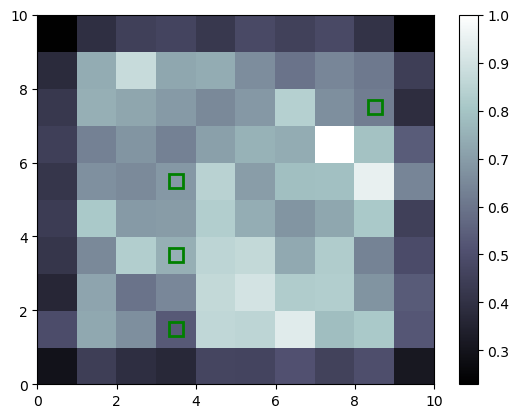

In [12]:
from pylab import bone,pcolor, colorbar ,plot , show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors=['r','g']
for i,x in enumerate(x_train):
    w = som.winner(x)
    plot(w[0]+0.5,
         w[1]+0.5,
        markers[y_train[i]],
        markeredgecolor = colors[y_train[i]],
        markerfacecolor = 'None',
        markersize = 10,
        markeredgewidth = 2)
show()